In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import os
import statsmodels.api as sm
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('Border_Crossing_Entry_Data.csv')
df.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
0,Roma,Texas,2310,US-Mexico Border,Dec 2023,Buses,46,26.404,-99.019,POINT (-99.018981 26.403928)
1,Del Rio,Texas,2302,US-Mexico Border,Dec 2023,Trucks,6552,29.327,-100.928,POINT (-100.927612 29.326784)
2,Willow Creek,Montana,3325,US-Canada Border,Jan 2024,Pedestrians,2,49.000,-109.731,POINT (-109.731333 48.999972)
3,Whitlash,Montana,3321,US-Canada Border,Jan 2024,Personal Vehicles,29,48.997,-111.258,POINT (-111.257916 48.99725)
4,Ysleta,Texas,2401,US-Mexico Border,Jan 2024,Personal Vehicle Passengers,521714,31.673,-106.335,POINT (-106.335449846028 31.6731261376859)


In [3]:
US_Canada = df[(df['Border'] == 'US-Canada Border') & (df['Measure']=='Trucks')]
US_Canada.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
5,Warroad,Minnesota,3423,US-Canada Border,Jan 2024,Trucks,837,48.999,-95.377,POINT (-95.376555 48.999)
6,Wildhorse,Montana,3323,US-Canada Border,Jan 2024,Trucks,20,48.999,-110.215,POINT (-110.215083 48.999361)
31,Fort Fairfield,Maine,107,US-Canada Border,Jan 2024,Trucks,525,46.765,-67.789,POINT (-67.789471 46.765323)
50,Fortuna,North Dakota,3417,US-Canada Border,Jan 2024,Trucks,228,49.000,-103.809,POINT (-103.80925 48.999555)
61,Metaline Falls,Washington,3025,US-Canada Border,Jan 2024,Trucks,370,49.000,-117.299,POINT (-117.299444 48.999972)


In [4]:
US_Canada.shape

(27670, 10)

In [5]:
US_Canada.isna().sum()

Port Name    0
State        0
Port Code    0
Border       0
Date         0
Measure      0
Value        0
Latitude     0
Longitude    0
Point        0
dtype: int64

In [6]:
US_Canada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27670 entries, 5 to 392551
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Port Name  27670 non-null  object 
 1   State      27670 non-null  object 
 2   Port Code  27670 non-null  int64  
 3   Border     27670 non-null  object 
 4   Date       27670 non-null  object 
 5   Measure    27670 non-null  object 
 6   Value      27670 non-null  int64  
 7   Latitude   27670 non-null  float64
 8   Longitude  27670 non-null  float64
 9   Point      27670 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.3+ MB


In [7]:
df1 = US_Canada[['State', 'Measure', 'Value']]

In [8]:
df1.head()

,State,Measure,Value
5,Minnesota,Trucks,837
6,Montana,Trucks,20
31,Maine,Trucks,525
50,North Dakota,Trucks,228
61,Washington,Trucks,370


In [9]:
df1

,State,Measure,Value
5,Minnesota,Trucks,837
6,Montana,Trucks,20
31,Maine,Trucks,525
50,North Dakota,Trucks,228
61,Washington,Trucks,370
...,...,...,...
392508,Montana,Trucks,55
392509,Minnesota,Trucks,3088
392547,North Dakota,Trucks,374
392550,North Dakota,Trucks,2750


In [10]:
agg_data = df1.groupby(['State', 'Measure'])['Value'].sum()

In [11]:
agg_data

State         Measure
Alaska        Trucks       287404
Idaho         Trucks      1692399
Maine         Trucks     10667220
Michigan      Trucks     68112301
Minnesota     Trucks      2293256
Montana       Trucks      4856745
New York      Trucks     46771228
North Dakota  Trucks     10376156
Vermont       Trucks      7152240
Washington    Trucks     18518825
Name: Value, dtype: int64

In [12]:
agg_data = agg_data.reset_index()
agg_data

,State,Measure,Value
0,Alaska,Trucks,287404
1,Idaho,Trucks,1692399
2,Maine,Trucks,10667220
3,Michigan,Trucks,68112301
4,Minnesota,Trucks,2293256
5,Montana,Trucks,4856745
6,New York,Trucks,46771228
7,North Dakota,Trucks,10376156
8,Vermont,Trucks,7152240
9,Washington,Trucks,18518825


In [13]:
agg_data.isna().sum()

State      0
Measure    0
Value      0
dtype: int64

In [14]:
fig = px.bar(agg_data, x='State', y='Value', title='Barplot of Aggregated Values by State', width= 700, height=500)
fig.update_layout(xaxis_title="State", yaxis_title="Value")
fig.show()

In [15]:
agg_data_sorted = agg_data.sort_values('Value', ascending=False)

In [16]:
agg_data_sorted

,State,Measure,Value
3,Michigan,Trucks,68112301
6,New York,Trucks,46771228
9,Washington,Trucks,18518825
2,Maine,Trucks,10667220
7,North Dakota,Trucks,10376156
8,Vermont,Trucks,7152240
5,Montana,Trucks,4856745
4,Minnesota,Trucks,2293256
1,Idaho,Trucks,1692399
0,Alaska,Trucks,287404


In [17]:
US_Canada_MI = US_Canada[US_Canada['State'] == 'Michigan']

In [18]:
US_Canada_MI

,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
74,Detroit,Michigan,3801,US-Canada Border,Jan 2024,Trucks,130404,42.332,-83.048,POINT (-83.047924 42.331685)
439,Port Huron,Michigan,3802,US-Canada Border,Jan 2024,Trucks,64502,42.999,-82.424,POINT (-82.423611 42.998611)
459,Sault Sainte Marie,Michigan,3803,US-Canada Border,Jan 2024,Trucks,2775,46.509,-84.361,POINT (-84.360833 46.508611)
838,Sault Sainte Marie,Michigan,3803,US-Canada Border,Feb 2024,Trucks,2557,46.509,-84.361,POINT (-84.360833 46.508611)
1279,Detroit,Michigan,3801,US-Canada Border,Feb 2024,Trucks,125834,42.332,-83.048,POINT (-83.047924 42.331685)
...,...,...,...,...,...,...,...,...,...,...
391538,Port Huron,Michigan,3802,US-Canada Border,Jul 1997,Trucks,50981,42.999,-82.424,POINT (-82.423611 42.998611)
391674,Port Huron,Michigan,3802,US-Canada Border,Aug 1996,Trucks,54627,42.999,-82.424,POINT (-82.423611 42.998611)
392051,Sault Sainte Marie,Michigan,3803,US-Canada Border,Nov 1997,Trucks,5170,46.509,-84.361,POINT (-84.360833 46.508611)
392270,Sault Sainte Marie,Michigan,3803,US-Canada Border,Aug 1997,Trucks,5616,46.509,-84.361,POINT (-84.360833 46.508611)


In [19]:
fig = px.box(US_Canada_MI, x='Port Name', y='Value', title='Boxplot of Values by Port Name', width= 700, height=500)
fig.update_layout(xaxis_title="Port Name", yaxis_title="Value")
fig.show()

In [20]:
agg_data = US_Canada_MI.groupby(['Port Name', 'Measure'])['Value'].sum()
agg_data = agg_data.reset_index()
agg_data

,Port Name,Measure,Value
0,Detroit,Trucks,44273169
1,Port Huron,Trucks,22397397
2,Sault Sainte Marie,Trucks,1441735


In [21]:
MI_TimeSeries = US_Canada_MI.groupby(['Date', 'Measure'])['Value'].sum()
MI_TimeSeries = MI_TimeSeries.reset_index()

In [22]:
MI_TimeSeries

,Date,Measure,Value
0,Apr 1996,Trucks,174848
1,Apr 1997,Trucks,189375
2,Apr 1998,Trucks,200998
3,Apr 1999,Trucks,219532
4,Apr 2000,Trucks,219048
...,...,...,...
336,Sep 2019,Trucks,203061
337,Sep 2020,Trucks,200972
338,Sep 2021,Trucks,188039
339,Sep 2022,Trucks,194498


In [23]:
MI_TimeSeries.isna().sum()

Date       0
Measure    0
Value      0
dtype: int64

In [24]:
MI_TimeSeries

,Date,Measure,Value
0,Apr 1996,Trucks,174848
1,Apr 1997,Trucks,189375
2,Apr 1998,Trucks,200998
3,Apr 1999,Trucks,219532
4,Apr 2000,Trucks,219048
...,...,...,...
336,Sep 2019,Trucks,203061
337,Sep 2020,Trucks,200972
338,Sep 2021,Trucks,188039
339,Sep 2022,Trucks,194498


In [25]:
MI_TimeSeries.isna().sum()

Date       0
Measure    0
Value      0
dtype: int64

In [26]:
MI_TimeSeries['Date'] = pd.to_datetime(MI_TimeSeries['Date'], format='%b %Y')


In [27]:
MI_TimeSeries

,Date,Measure,Value
0,1996-04-01,Trucks,174848
1,1997-04-01,Trucks,189375
2,1998-04-01,Trucks,200998
3,1999-04-01,Trucks,219532
4,2000-04-01,Trucks,219048
...,...,...,...
336,2019-09-01,Trucks,203061
337,2020-09-01,Trucks,200972
338,2021-09-01,Trucks,188039
339,2022-09-01,Trucks,194498


In [28]:
MI_TimeSeries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     341 non-null    datetime64[ns]
 1   Measure  341 non-null    object        
 2   Value    341 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 8.1+ KB


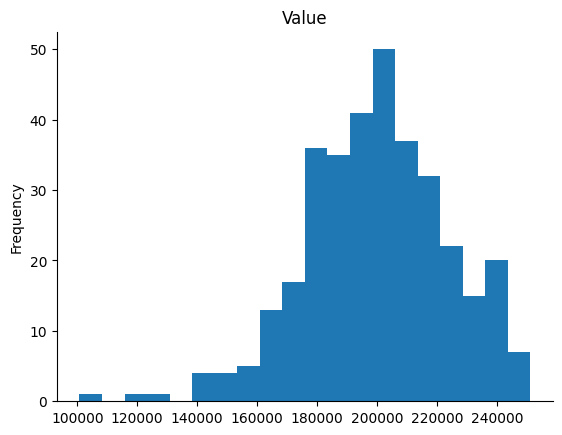

In [29]:
MI_TimeSeries['Value'].plot(kind='hist', bins=20, title='Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

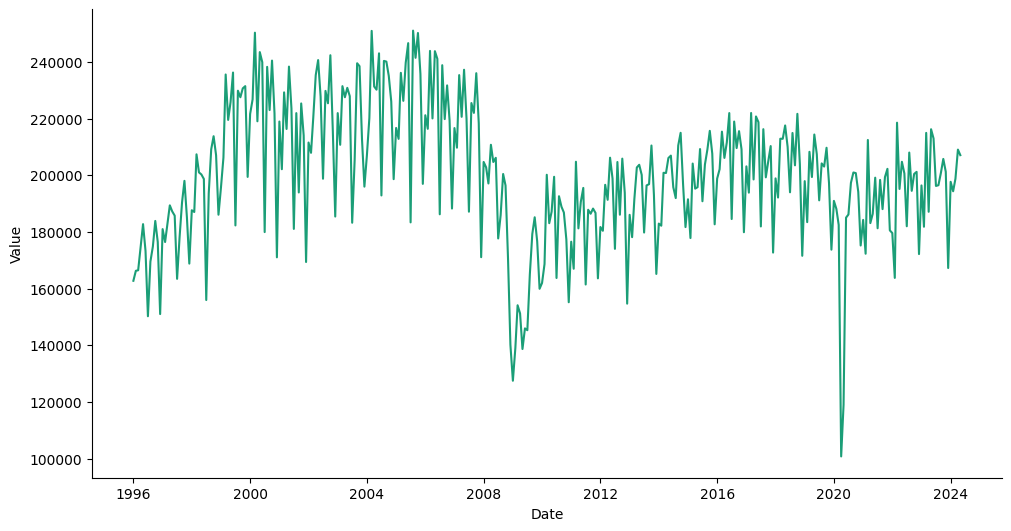

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Value']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = MI_TimeSeries.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Value')

In [31]:
MI_TimeSeries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     341 non-null    datetime64[ns]
 1   Measure  341 non-null    object        
 2   Value    341 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 8.1+ KB


In [32]:
MI_TimeSeries_Plot = MI_TimeSeries.set_index('Date')
MI_TimeSeries_Plot

,Measure,Value
Date,,
1996-04-01,Trucks,174848
1997-04-01,Trucks,189375
1998-04-01,Trucks,200998
1999-04-01,Trucks,219532
2000-04-01,Trucks,219048
...,...,...
2019-09-01,Trucks,203061
2020-09-01,Trucks,200972
2021-09-01,Trucks,188039


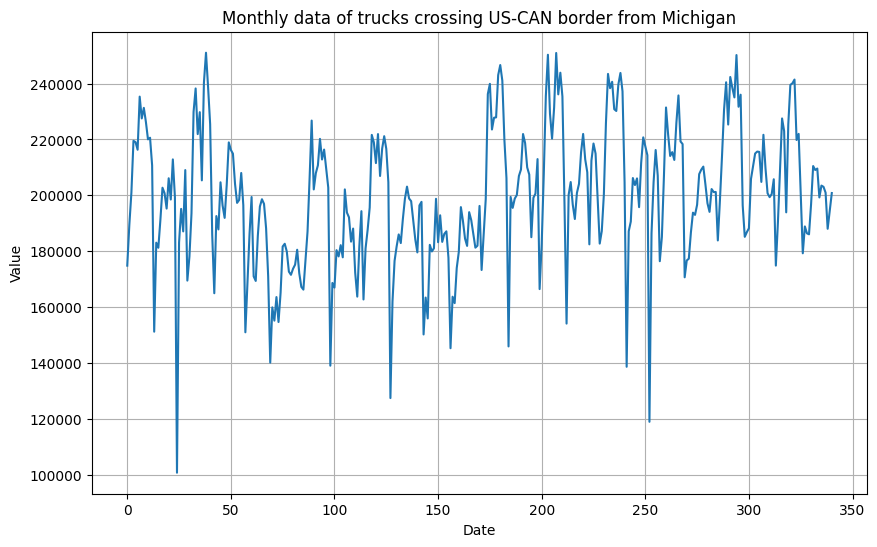

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(MI_TimeSeries.index, MI_TimeSeries['Value'])
plt.title('Monthly data of trucks crossing US-CAN border from Michigan')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [34]:
ACF = MI_TimeSeries_Plot.groupby(['Date', 'Measure'])['Value'].sum()
ACF = ACF.reset_index()
ACF.set_index('Date', inplace=True)
ACF

,Measure,Value
Date,,
1996-01-01,Trucks,162742
1996-02-01,Trucks,166263
1996-03-01,Trucks,166456
1996-04-01,Trucks,174848
1996-05-01,Trucks,182741
...,...,...
2024-01-01,Trucks,197681
2024-02-01,Trucks,194346
2024-03-01,Trucks,198762


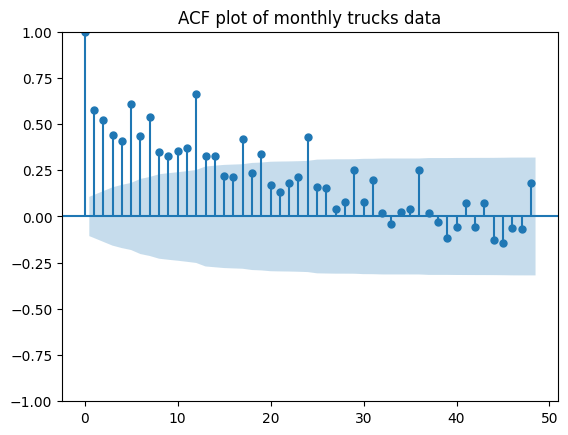

In [35]:
plot_acf(ACF['Value'], lags=48)
plt.title("ACF plot of monthly trucks data")
plt.show()

In [36]:
fig = px.line(ACF, x=ACF.index, y='Value', title='Line plot of ACF')
fig.update_layout(xaxis_title="Date", yaxis_title="Value")
fig.show()

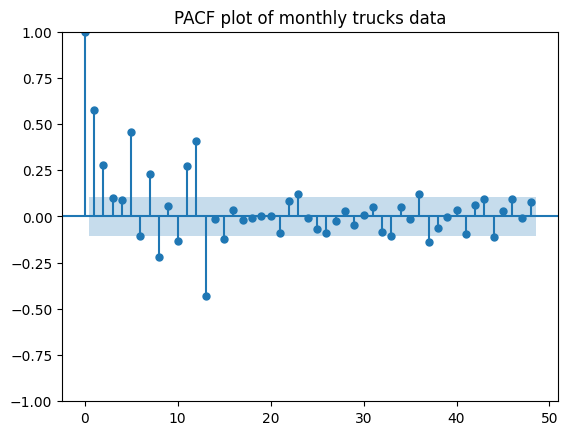

In [37]:
plot_pacf(ACF['Value'], lags = 48)
plt.title("PACF plot of monthly trucks data")
plt.show()

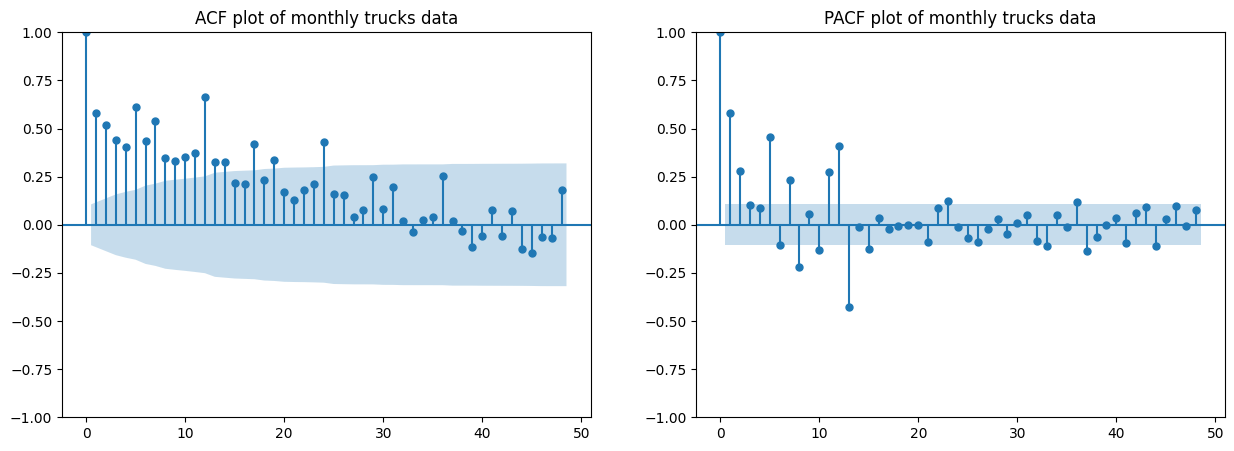

In [38]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Plot ACF
plot_acf(ACF['Value'], lags=48, ax=axes[0])
axes[0].set_title("ACF plot of monthly trucks data")

# Plot PACF
plot_pacf(ACF['Value'], lags=48, ax=axes[1])
axes[1].set_title("PACF plot of monthly trucks data")

fig = px.line(ACF, x=ACF.index, y='Value', title='Line plot of ACF', width=700, height=500)
fig.update_layout(xaxis_title="Date", yaxis_title="Value")
fig.show()

plt.show()


1. Data in the ACF plot without difference shows some signs of trends with less stationarity.

2. Another insight we can see is that trucks number have dropped  fairly after 2010 with highest figure of 250,000 around year 2005 while highest figure of 220,000 around year 2008. **bold text**

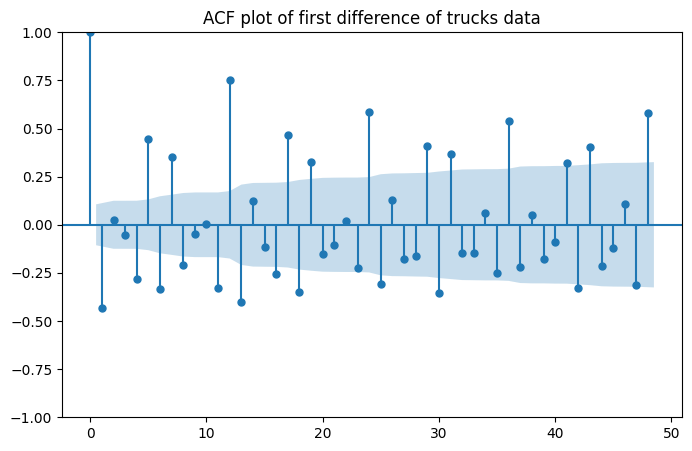

In [39]:
# Calculate the first difference of the 'Value' column
ACF_diff = ACF['Value'].diff()

# Plot the ACF of the differenced data
fig, ax = plt.subplots(figsize=(8, 5))
plot_acf(ACF_diff.dropna(), lags=48, ax=ax)
plt.title("ACF plot of first difference of trucks data")
plt.show()

In [40]:
fig = px.line(ACF_diff, x=ACF.index, y='Value', title='Line plot of first difference of trucks data', width=700, height=500)
fig.update_layout(xaxis_title="Date", yaxis_title="Value")
fig.show()

plt.show()

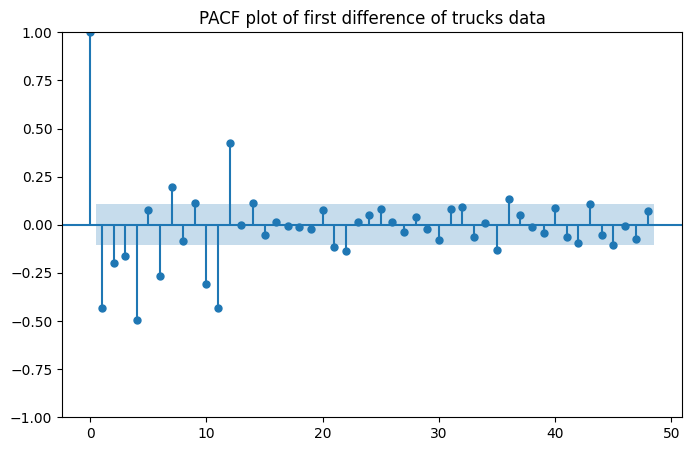

In [41]:
# Plot the ACF of the differenced data
fig, ax = plt.subplots(figsize=(8, 5))
plot_pacf(ACF_diff.dropna(), lags=48, ax=ax)
plt.title("PACF plot of first difference of trucks data")
plt.show()

**After first difference the data looks quite stationary and it does not seem that we would need 2nd difference. But to avoid any assumptions we will try to take second difference and see if there is any change to the stationarity of data.**

In [42]:
from statsmodels.tsa.stattools import kpss

#perform kpss test for the first difference
statistic, p_value, lags, critical_values = kpss(ACF_diff.dropna(), regression='c', nlags="auto")

#format output
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {lags}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')

KPSS Statistic: 0.10896934896368528
p-value: 0.1
num lags: 45
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


<ipython-input-42-d23c92ad1d3a>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




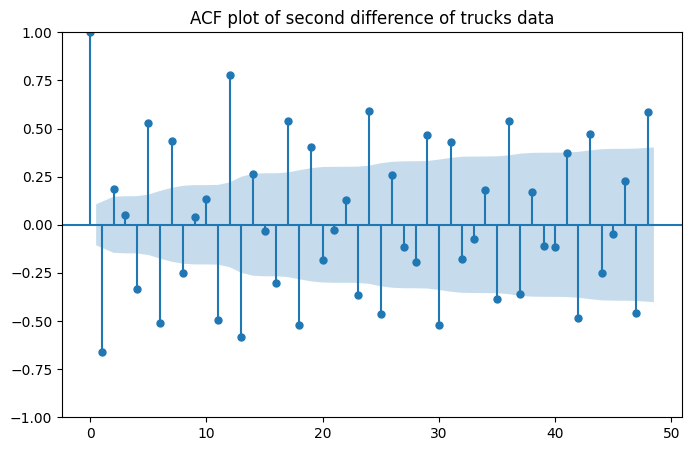

In [43]:
# Calculate the second difference of the 'Value' column
ACF_diff2 = ACF['Value'].diff().diff()

# Plot the ACF of the second differenced data
fig, ax = plt.subplots(figsize=(8, 5))
plot_acf(ACF_diff2.dropna(), lags=48, ax=ax)
plt.title("ACF plot of second difference of trucks data")
plt.show()

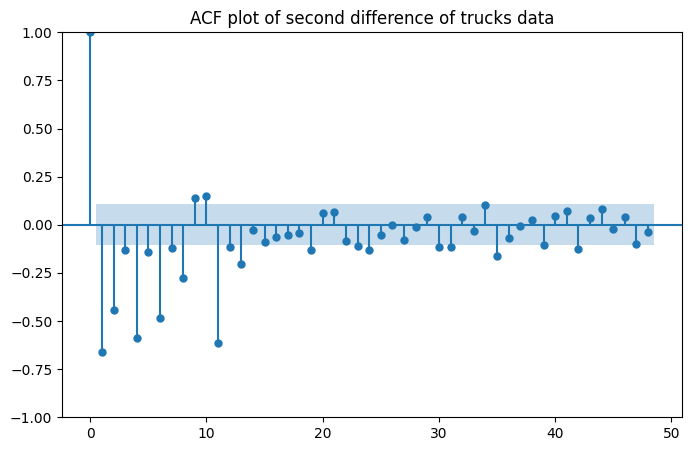

In [44]:
# Calculate the second difference of the 'Value' column
ACF_diff2 = ACF['Value'].diff().diff()

# Plot the ACF of the second differenced data
fig, ax = plt.subplots(figsize=(8, 5))
plot_pacf(ACF_diff2.dropna(), lags=48, ax=ax)
plt.title("ACF plot of second difference of trucks data")
plt.show()

In [45]:
fig = px.line(ACF_diff2, x=ACF.index, y='Value', title='Line plot of first difference of trucks data', width=700, height=500)
fig.update_layout(xaxis_title="Date", yaxis_title="Value")
fig.show()

plt.show()

In [46]:
#KPSS test for the second difference
statistic, p_value, lags, critical_values = kpss(ACF_diff2.dropna(), regression='c', nlags="auto")

#format output
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {lags}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')

KPSS Statistic: 0.01225234554619774
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


<ipython-input-46-e3743cbd33b5>:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




**From** the visual review and hypothesis test of stationarity, it is fairly to make below assumptions :

1.   ACF plot of original data shows positive autocorrelation which indicates that present values of trucks crossing border have a correlation with past values.

2. There seems to be a slight trend in the line plot of original data and some seasonal variations as well. We will use decomposition plots for check for trend and seasonality in order to check what time series models will be appropriate to fit the data.

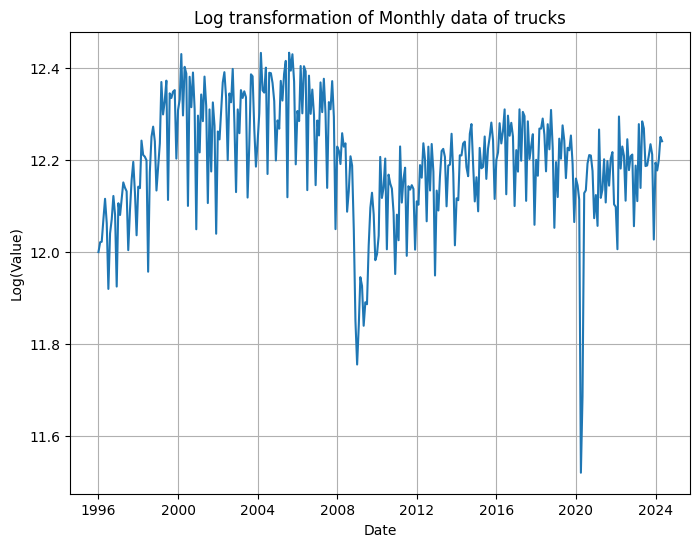

In [47]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=MI_TimeSeries_Plot.index, y=np.log(MI_TimeSeries_Plot['Value']))
plt.title('Log transformation of Monthly data of trucks')
plt.xlabel('Date')
plt.ylabel('Log(Value)')
plt.grid(True)
plt.show()

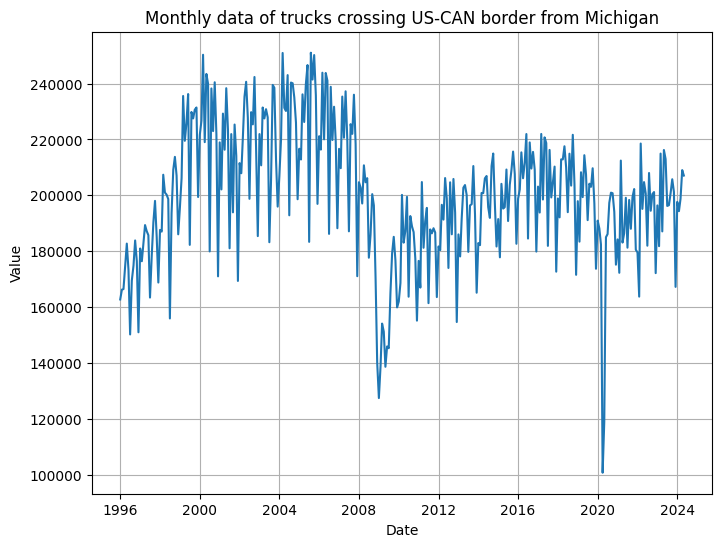

In [48]:
plt.figure(figsize=(8, 6))
sns.lineplot(x = MI_TimeSeries_Plot.index,y =  MI_TimeSeries_Plot['Value'])
plt.title('Monthly data of trucks crossing US-CAN border from Michigan')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [49]:
from scipy.stats import boxcox

transformed_data, lambda_value = boxcox(MI_TimeSeries_Plot['Value'])

print("Lambda value:", lambda_value)

Lambda value: 1.873548528936237


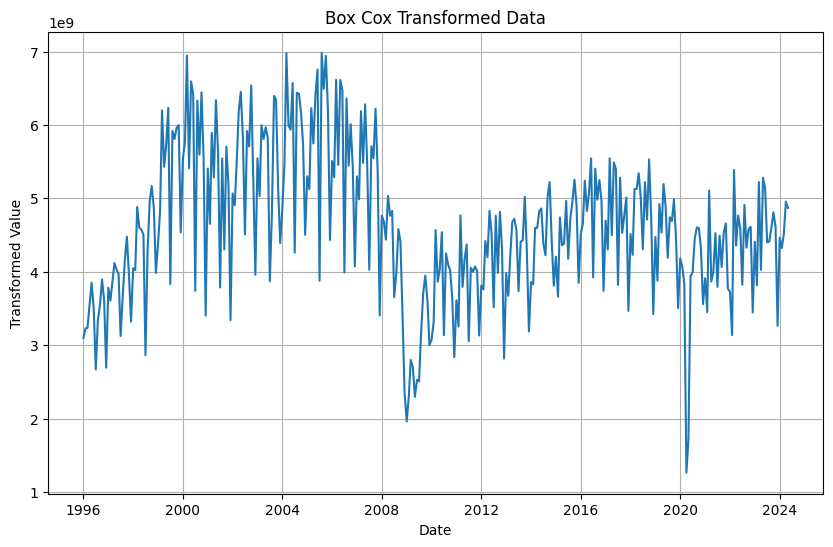

In [50]:
# Create a new DataFrame with transformed data
transformed_df = MI_TimeSeries_Plot.copy()
transformed_df['Value'] = transformed_data

# Plot the transformed data
plt.figure(figsize=(10, 6))
sns.lineplot(x = transformed_df.index, y = transformed_df['Value'])
plt.title('Box Cox Transformed Data')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.grid(True)
plt.show()

**Comparison :**

As seen in the above plot the log transformation shows some promisign results in capturing the variation within the data while Box Cox transformation is not much effective for the same.


In [51]:
MI_TimeSeries_Plot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341 entries, 1996-04-01 to 2023-09-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Measure  341 non-null    object
 1   Value    341 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.0+ KB


In [52]:
MI_Data_b2009 = MI_TimeSeries_Plot[MI_TimeSeries_Plot.index.year <= 2009]
MI_Data_a2009 = MI_TimeSeries_Plot[MI_TimeSeries_Plot.index.year >= 2010].iloc[:len(MI_Data_b2009)]

In [53]:
MI_Data_a2009

,Measure,Value
Date,,
2010-04-01,Trucks,183077
2011-04-01,Trucks,181245
2012-04-01,Trucks,191326
2013-04-01,Trucks,202743
2014-04-01,Trucks,200797
...,...,...
2014-09-01,Trucks,210497
2015-09-01,Trucks,209077
2016-09-01,Trucks,209600


In [54]:
MI_Data_b2009

,Measure,Value
Date,,
1996-04-01,Trucks,174848
1997-04-01,Trucks,189375
1998-04-01,Trucks,200998
1999-04-01,Trucks,219532
2000-04-01,Trucks,219048
...,...,...
2005-09-01,Trucks,241458
2006-09-01,Trucks,219818
2007-09-01,Trucks,222021


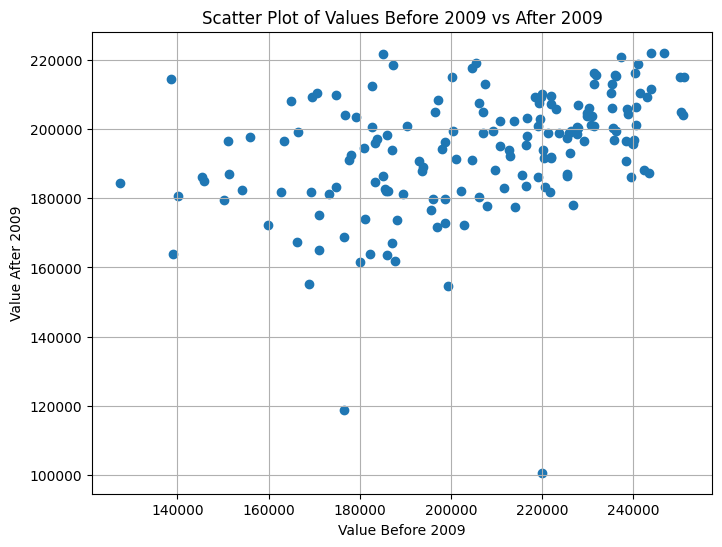

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(MI_Data_b2009['Value'], MI_Data_a2009['Value'])
plt.title('Scatter Plot of Values Before 2009 vs After 2009')
plt.xlabel('Value Before 2009')
plt.ylabel('Value After 2009')
plt.grid(True)
plt.show()

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [57]:
MI_TimeSeries_Plot

,Measure,Value
Date,,
1996-04-01,Trucks,174848
1997-04-01,Trucks,189375
1998-04-01,Trucks,200998
1999-04-01,Trucks,219532
2000-04-01,Trucks,219048
...,...,...
2019-09-01,Trucks,203061
2020-09-01,Trucks,200972
2021-09-01,Trucks,188039


In [112]:
MI_TimeSeries_Plot.reset_index(inplace=True)

In [113]:
MI_TimeSeries_Plot["Date"] = pd.to_datetime(MI_TimeSeries_Plot["Date"], format= "%Y %b")

In [114]:
MI_TimeSeries_Plot.sort_values(by="Date", inplace=True)

In [115]:
MI_TimeSeries_Plot

,Date,Measure,Value
0,1996-01-01,Trucks,162742
1,1996-02-01,Trucks,166263
2,1996-03-01,Trucks,166456
3,1996-04-01,Trucks,174848
4,1996-05-01,Trucks,182741
...,...,...,...
336,2024-01-01,Trucks,197681
337,2024-02-01,Trucks,194346
338,2024-03-01,Trucks,198762
339,2024-04-01,Trucks,209055


In [139]:
train = MI_TimeSeries_Plot[0:300]
test = MI_TimeSeries_Plot[300:]

In [140]:
train.reset_index(inplace=True)

In [141]:
train.set_index("Date", inplace=True)

In [142]:
test.reset_index(inplace=True)

In [143]:
test.set_index("Date", inplace=True)

In [144]:
test

,index,Measure,Value
Date,,,
2021-01-01,300,Trucks,184237
2021-02-01,301,Trucks,172292
2021-03-01,302,Trucks,212453
2021-04-01,303,Trucks,183108
2021-05-01,304,Trucks,186399
2021-06-01,305,Trucks,199140
2021-07-01,306,Trucks,181284
2021-08-01,307,Trucks,198357
2021-09-01,308,Trucks,188039


In [145]:
train.drop(columns=["index"], inplace=True)
train

,Measure,Value
Date,,
1996-01-01,Trucks,162742
1996-02-01,Trucks,166263
1996-03-01,Trucks,166456
1996-04-01,Trucks,174848
1996-05-01,Trucks,182741
...,...,...
2020-08-01,Trucks,197312
2020-09-01,Trucks,200972
2020-10-01,Trucks,200765


In [146]:
test.drop(columns=["index"], inplace=True)
test

,Measure,Value
Date,,
2021-01-01,Trucks,184237
2021-02-01,Trucks,172292
2021-03-01,Trucks,212453
2021-04-01,Trucks,183108
2021-05-01,Trucks,186399
2021-06-01,Trucks,199140
2021-07-01,Trucks,181284
2021-08-01,Trucks,198357
2021-09-01,Trucks,188039


In [147]:
train.drop(columns=["Measure"], inplace=True)

In [149]:
test.drop(columns=["Measure"], inplace=True)

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 1996-01-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Value   300 non-null    int64
dtypes: int64(1)
memory usage: 4.7 KB


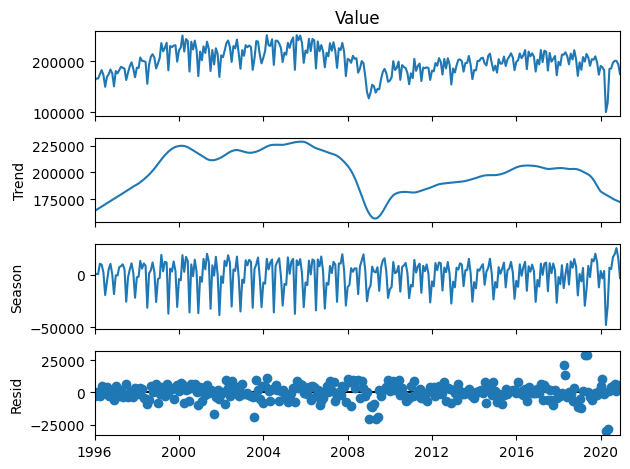

In [150]:
res1 = STL(train["Value"], period=12).fit()
res1.plot()
plt.show()

In [151]:
trend = res1.trend
trend

Date
1996-01-01    163864.374220
1996-02-01    164927.846906
1996-03-01    165983.081111
1996-04-01    167031.830113
1996-05-01    168076.613957
                  ...      
2020-08-01    175187.126016
2020-09-01    174353.124461
2020-10-01    173597.493509
2020-11-01    172920.285051
2020-12-01    172318.621818
Name: trend, Length: 300, dtype: float64

In [152]:
value = train["Value"]
value

Date
1996-01-01    162742
1996-02-01    166263
1996-03-01    166456
1996-04-01    174848
1996-05-01    182741
               ...  
2020-08-01    197312
2020-09-01    200972
2020-10-01    200765
2020-11-01    194101
2020-12-01    175196
Name: Value, Length: 300, dtype: int64

In [153]:
linear_model_train = pd.concat([trend, value], axis=1)
linear_model_train

,trend,Value
Date,,
1996-01-01,163864.374220,162742
1996-02-01,164927.846906,166263
1996-03-01,165983.081111,166456
1996-04-01,167031.830113,174848
1996-05-01,168076.613957,182741
...,...,...
2020-08-01,175187.126016,197312
2020-09-01,174353.124461,200972
2020-10-01,173597.493509,200765


In [154]:
from statsmodels.api import OLS
linear_fit = OLS(linear_model_train['Value'], linear_model_train['trend']).fit()

In [155]:
linear_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Value   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          4.550e+04
Date:                Wed, 07 Aug 2024   Prob (F-statistic):                        0.00
Time:                        05:35:51   Log-Likelihood:                         -3335.7
No. Observations:                 300   AIC:                                      6673.
Df Residuals:                     299   BIC:                                      6677.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
trend          1.0012      0.005    213.304      0.000       0.992       1.010
==============================================================================
Omnibus:                       63.376   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.305
Skew:                          -1.155   Prob(JB):                     4.10e-25
Kurtosis:                       4.909   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

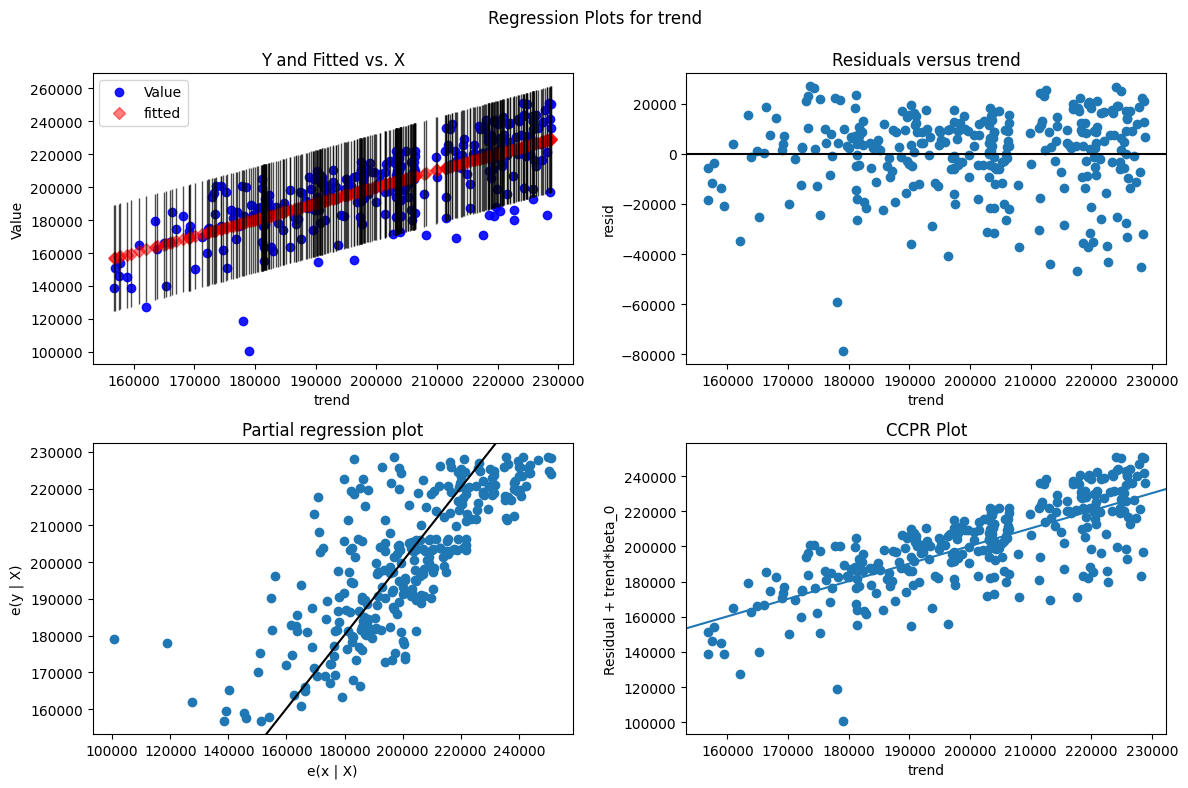

In [156]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_regress_exog(linear_fit, "trend", fig=fig)

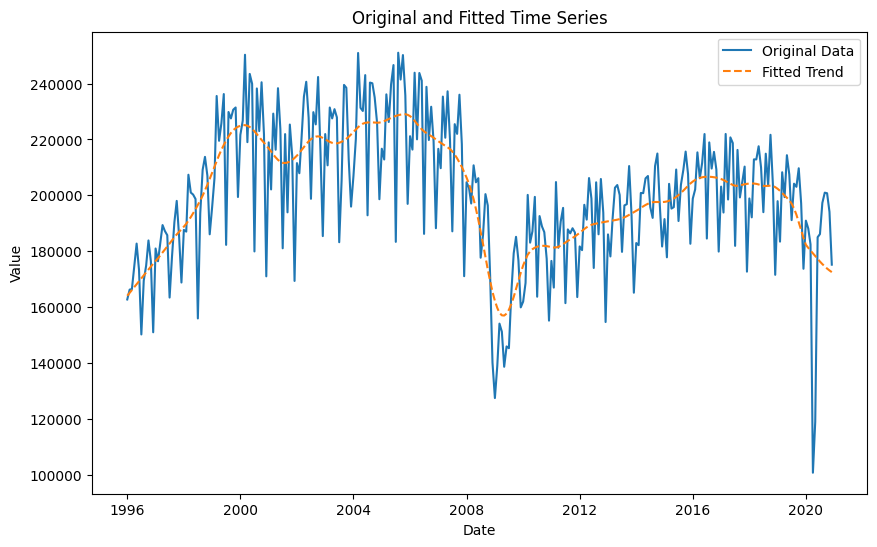

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Value'], label='Original Data')
plt.plot(train.index, linear_fit.fittedvalues, label='Fitted Trend', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original and Fitted Time Series')
plt.legend()
plt.show()

In [158]:
forecast = linear_fit.predict(test)

In [159]:
forecast

Date
2021-01-01    184460.900855
2021-02-01    172501.384250
2021-03-01    212711.191396
2021-04-01    183330.528795
2021-05-01    186625.528305
2021-06-01    199382.012279
2021-07-01    181504.312112
2021-08-01    198598.060709
2021-09-01    188267.521376
2021-10-01    199608.286934
2021-11-01    202503.801544
2021-12-01    180760.409153
2022-01-01    179808.253415
2022-02-01    163961.017851
2022-03-01    218818.604648
2022-04-01    195396.174221
2022-05-01    204993.823963
2022-06-01    200888.841286
2022-07-01    182209.167674
2022-08-01    208263.793091
2022-09-01    194734.370916
2022-10-01    200698.610381
2022-11-01    201437.507263
2022-12-01    172379.235985
2023-01-01    196643.688468
2023-02-01    182037.959860
2023-03-01    215217.233260
2023-04-01    187329.382652
2023-05-01    216502.793689
2023-06-01    213244.839144
2023-07-01    196459.464856
2023-08-01    196721.783261
2023-09-01    201079.072190
2023-10-01    206017.065986
2023-11-01    201457.531569
2023-12-01    1

In [161]:
forecast = pd.DataFrame(forecast, columns=['Forecast'])

In [162]:
forecast['Value'] = test['Value']

In [165]:
forecast.index

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

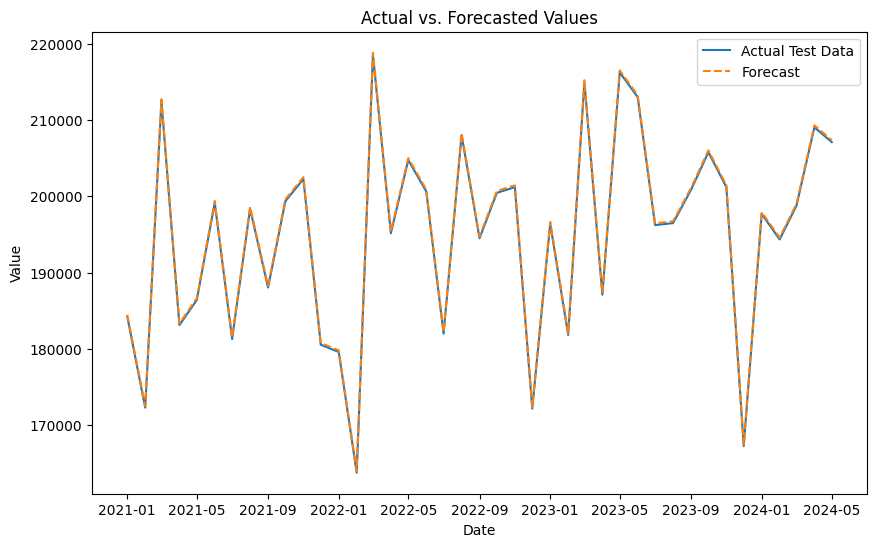

In [166]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Value'], label='Actual Test Data')
plt.plot(test.index, forecast['Forecast'], label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Forecasted Values')
plt.legend()
plt.show()

In [167]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Value'], forecast['Forecast'])
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 56385.692735409786
Root Mean Squared Error: 237.45671760430318


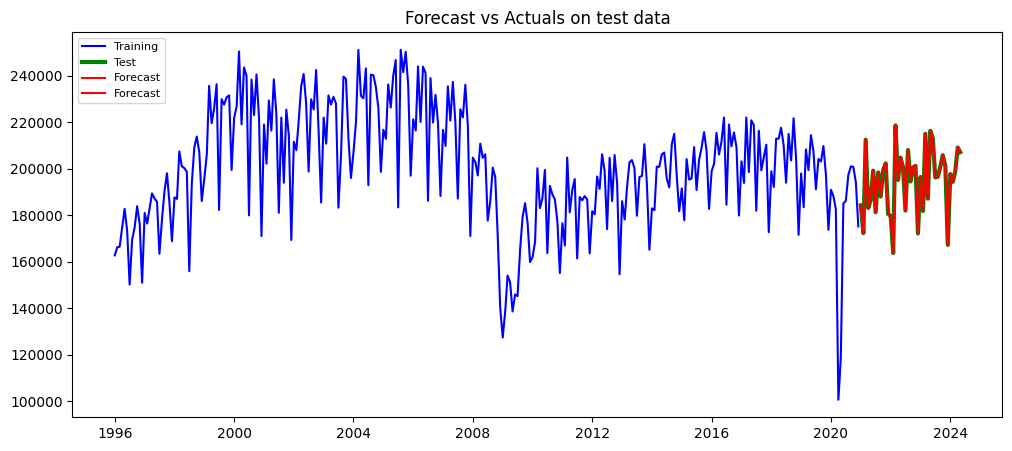

In [168]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training', color = 'blue')
plt.plot(test, label='Test', color = 'green', linewidth = 3)
plt.plot(forecast, label='Forecast', color = 'red')
plt.title('Forecast vs Actuals on test data')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [199]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



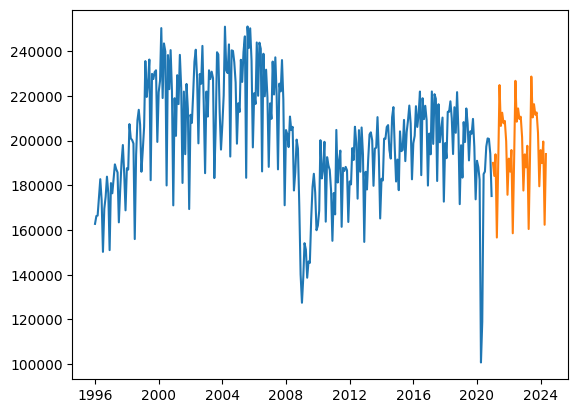

In [206]:
#Exponential Smoothing
etsfit = ETSModel(train["Value"], trend= "add", seasonal="add", error="add", seasonal_periods=12).fit()
fcast2 = etsfit.forecast(len(test))
plt.plot(train)
plt.plot(fcast2)

In [202]:
etsfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Value   No. Observations:                  300
Model:                       ETS(AAA)   Log Likelihood               -3280.190
Date:                Wed, 07 Aug 2024   AIC                           6596.380
Time:                        07:17:40   BIC                           6663.048
Sample:                    01-01-1996   HQIC                          6623.061
                         - 12-01-2020   Scale                    183928318.402
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4089      0.033     12.466      0.000       0.345       0.473
smoothing_trend         0.0026        nan        nan        nan         nan         nan
smoothing_seasonal      0.4647        nan        nan        nan         nan         nan
initial_level        1.693e+05   8706.558     19.451      0.000    1.52e+05    1.86e+05
initial_trend         992.1818        nan        nan        nan         nan         nan
initial_seasonal.0   1.916e+04   5128.679      3.735      0.000    9105.432    2.92e+04
initial_seasonal.1   2.077e+04   9147.413      2.270      0.023    2837.515    3.87e+04
initial_seasonal.2   3.941e+04   8910.689      4.423      0.000    2.19e+04    5.69e+04
initial_seasonal.3   2.658e+04   9342.507      2.845      0.004    8269.001    4.49e+04
initial_seasonal.4   3.248e+04   9297.403      3.493      0.000    1.43e+04    5.07e+04
initial_seasonal.5   3.275e+04   2543.269     12.878      0.000    2.78e+04    3.77e+04
initial_seasonal.6  -6848.1458        nan        nan        nan         nan         nan
initial_seasonal.7   2.169e+04   7293.238      2.974      0.003    7392.496     3.6e+04
initial_seasonal.8   2.793e+04   8793.755      3.176      0.001    1.07e+04    4.52e+04
initial_seasonal.9   3.268e+04   8780.918      3.722      0.000    1.55e+04    4.99e+04
initial_seasonal.10  2.503e+04   9423.091      2.656      0.008    6558.466    4.35e+04
initial_seasonal.11          0   8361.085          0      1.000   -1.64e+04    1.64e+04
===================================================================================
Ljung-Box (Q):                       83.61   Jarque-Bera (JB):               684.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.90
Prob(H) (two-sided):                  0.46   Kurtosis:                        10.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+16. Standard errors may be unstable.
"""

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys


from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [205]:
mse = mean_squared_error(test['Value'], fcast2)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 314951730.84011936
Root Mean Squared Error: 17746.879467673167


In [209]:
rmse(test['Value'], fcast2)

17746.879467673167

In [212]:
rmse(test['Value'], forecast['Forecast'])

237.45671760430318

In [ ]:
# MONTE CARLO SIMULATION

# MONTE CARLO SIMULATION

FC of launch= USD 300,000 <br>
VC=USD 160 - USD 240 per unit with Average , USD 200 per unit <br> <br>

Sale price:  USD 300 per unit <br>
Demand range: 0-20,0000 <br>
Average of 4000 units

In [11]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

In [12]:
#Constant variables:
Fixed_Cost = 300000
Selling_Price = 300

#Base Case:
Variable_cost = 200
Demand = 4000    

In [13]:
Demand=1000*np.random.gamma(3,2,1000000)
Variable_Cost=np.random.uniform(160,240,1000000)
Earnings=(Demand * Selling_Price) - (Fixed_Cost + (Variable_cost * Demand))

In [14]:
#Base Case
Revenue=Demand*Selling_Price
Cost_incurred=Fixed_Cost + (Variable_cost * Demand)
Earnings= Revenue - Cost_incurred

In [15]:
#Base Earnings
Earnings

array([421186.80586393,  -2690.00610281, 165482.40704919, ...,
          686.97465344, 194112.25489745, -59372.55603669])

In [16]:
print(Demand)
print(Variable_Cost)
print(Earnings)

[7211.86805864 2973.09993897 4654.82407049 ... 3006.86974653 4941.12254897
 2406.27443963]
[181.78229619 200.19081826 169.41702563 ... 221.27490347 229.62168639
 166.50424353]
[421186.80586393  -2690.00610281 165482.40704919 ...    686.97465344
 194112.25489745 -59372.55603669]


In [17]:
min(Earnings)

-295200.6189873474

In [18]:
max(Earnings)

4037907.498153815

In [19]:
len(Earnings)

1000000

In [20]:
montylist= np.zeros(1000000)

for i in range(0,len(Earnings)):
    if Earnings[i] < 0:
        montylist[i]=1    

In [21]:
sum(montylist)/len(Earnings)

0.191714

In [22]:
#Average Profit
Earnings.mean()

299668.1375249446

# LINEAR OPTIMIZATION

Monthly advertisment budget: $1,000 <br>
Newspaper and Radio<br>

Newspaper=2*radio

# Constraints
Atleast 25 percent of budget spent on each media ( Greater than equal to)

Index scale: 0 to 100
Metrics : close to 100 , more audience exposure
Index of newspaper = 50
Index of radio = 80

Problem Statement:
How should budget be allocated, maximize value of the index?




In [23]:
#Linear Optimization problem solving
from scipy import optimize
from scipy.optimize import linprog
import matplotlib.pyplot as plt


# Advertising budget of newspaper = N
# Advertising budget of radio = R

# N + R = 1000
#N-2R >= 0

# Constraints= N>=250 , R >=250


# c is where we put coef in front of objective function
c=[-50,-80]

# coef in front of the constraints on the left
A= [[1, 1], [1,-2], [1,0], [0,1]]

#constraints on right side
B=[1000,0,250,250]

In [24]:
res = linprog(c, A_ub=A, b_ub=B)
res.fun

-32500.0

In [25]:
res.x

array([250., 250.])

In [26]:
res.ineqlin

  residual: [ 5.000e+02  2.500e+02  0.000e+00  0.000e+00]
 marginals: [-0.000e+00 -0.000e+00 -5.000e+01 -8.000e+01]

In [27]:
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -32500.0
              x: [ 2.500e+02  2.500e+02]
            nit: 0
          lower:  residual: [ 2.500e+02  2.500e+02]
                 marginals: [ 0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf]
                 marginals: [ 0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 5.000e+02  2.500e+02  0.000e+00  0.000e+00]
                 marginals: [-0.000e+00 -0.000e+00 -5.000e+01 -8.000e+01]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

# NON- LINEAR OPTIMIZATION

In [29]:
import numpy as np
from scipy.optimize import LinearConstraint
from scipy.optimize import milp
from scipy.optimize import Bounds
from scipy.optimize import minimize

In [30]:
fun = lambda x: 222*x[0] + (-0.6) * x[0]**2 + 270*x[1] +(-0.64)*x[1]**2 + (x[0] * x[1] *0.45)
cons = ({"type":"ineq", "fun":lambda x: (-0.6)*x[0]+0.35*x[1]+222},
       {"type":"ineq", "fun":lambda x: (0.10)*x[0]-(0.64)*x[1]+270})

bnds = ((0,None),(0,None))
res = minimize(fun, (0,0), method="SLSQP", bounds=bnds, constraints=cons)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0
       x: [ 0.000e+00  0.000e+00]
     nit: 5
     jac: [ 2.220e+02  2.700e+02]
    nfev: 3
    njev: 1